# MonReader

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
from skimage.io import imread
from skimage.transform import resize, rotate, AffineTransform, warp
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications import *
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

I will be attempting to create a neural network that is able to determine whether or not a page from a book is being flipped.

# Data Processing

In [2]:
## get images and split into training, testing, and validation sets

train_dataset = tf.keras.utils.image_dataset_from_directory('./images/training',
                                                            shuffle=True,
                                                            batch_size=32,
                                                            validation_split=0.2,
                                                            subset='training',
                                                            seed=27,
                                                            image_size=(224, 224))

validation_dataset = tf.keras.utils.image_dataset_from_directory('./images/training',
                                                                 shuffle=True,
                                                                 batch_size=32,
                                                                 validation_split=0.2,
                                                                 subset='validation',
                                                                 seed=27,
                                                                 image_size=(224, 224))

test_dataset = tf.keras.utils.image_dataset_from_directory('./images/testing',
                                                           shuffle=True,
                                                           batch_size=597,
                                                           image_size=(224, 224)) 

Found 2392 files belonging to 2 classes.
Using 1914 files for training.
Found 2392 files belonging to 2 classes.
Using 478 files for validation.
Found 597 files belonging to 2 classes.


In [3]:
## separate test images and labels for model evaluation and metrics

test_images, test_labels = next(iter(test_dataset))

Let's take a look at the data to see the images and their classes.

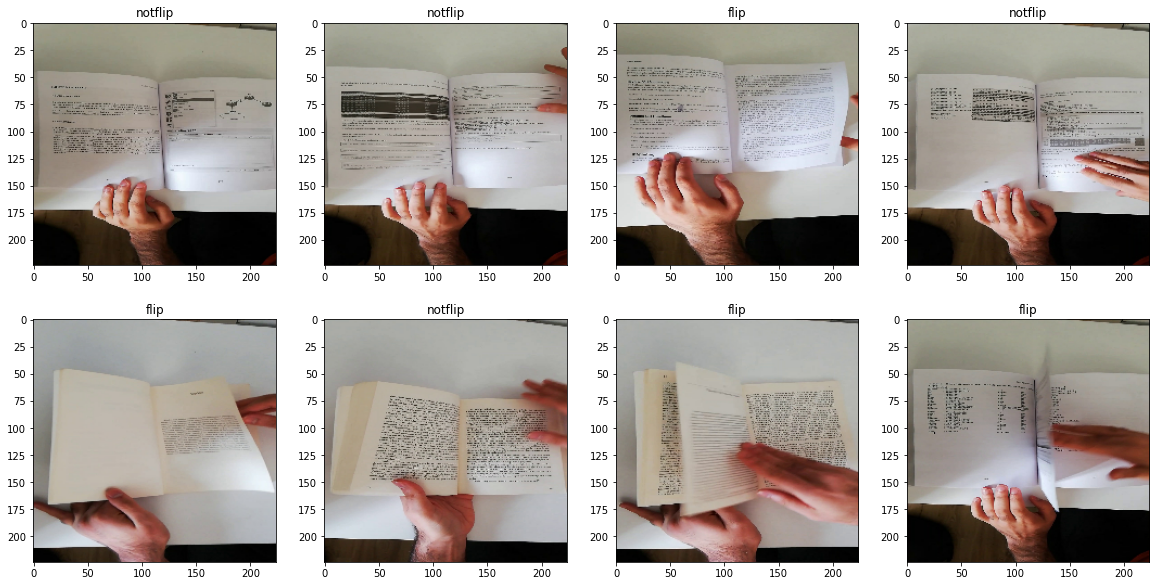

In [130]:
plt.figure(figsize=(20, 10))
class_names = train_dataset.class_names
for images, labels in train_dataset.take(1):
    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])

## Image Augmentation

I'll create an image augmentation layer to use for the CNN models. I'll be using a random rotation and a random flip of the images.

In [25]:
## create image augmentation layer for models

img_augmentation = models.Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomFlip()
    ])

# Transfer Learning

## ResNet

In [23]:
## load up Resnet model

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
resnet.trainable=False
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [108]:
## create a full model that incorporates the resnet model

inputs = tf.keras.Input(shape=(224, 224, 3))
x = img_augmentation(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = resnet(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(1, activation='sigmoid', name='pred')(x)

resnet_train = tf.keras.Model(inputs=inputs, outputs=output)
resnet_train.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_35 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_6   (None, 2048)             0   

In [109]:
resnet_train.compile(loss='binary_crossentropy', 
                     optimizer=tf.keras.optimizers.Adam(lr=.001, decay=0.01), 
                     metrics=['accuracy'])

In [110]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)

In [111]:
hist1 = resnet_train.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=[es])

Epoch 1/50
60/60 [==============================] - 17s 228ms/step - loss: 0.4979 - accuracy: 0.7644 - val_loss: 0.3293 - val_accuracy: 0.8703
Epoch 2/50
60/60 [==============================] - 12s 199ms/step - loss: 0.3235 - accuracy: 0.8548 - val_loss: 0.3257 - val_accuracy: 0.8536
Epoch 3/50
60/60 [==============================] - 13s 206ms/step - loss: 0.2961 - accuracy: 0.8741 - val_loss: 0.2831 - val_accuracy: 0.8975
Epoch 4/50
60/60 [==============================] - 13s 205ms/step - loss: 0.2494 - accuracy: 0.8976 - val_loss: 0.1918 - val_accuracy: 0.9351
Epoch 5/50
60/60 [==============================] - 12s 198ms/step - loss: 0.2553 - accuracy: 0.8918 - val_loss: 0.1635 - val_accuracy: 0.9456
Epoch 6/50
60/60 [==============================] - 13s 204ms/step - loss: 0.2299 - accuracy: 0.9049 - val_loss: 0.1669 - val_accuracy: 0.9435
Epoch 7/50
60/60 [==============================] - 13s 202ms/step - loss: 0.1984 - accuracy: 0.9227 - val_loss: 0.1381 - val_accuracy: 0.9519

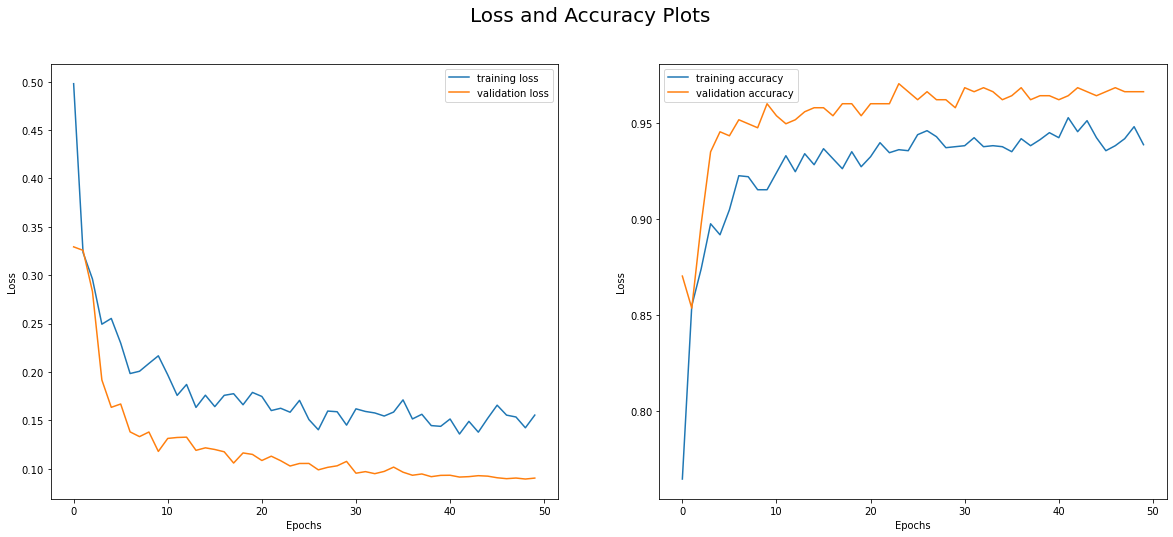

In [112]:
# plot training loss and accuracy

plt.figure(figsize=(20, 8))
plt.suptitle('Loss and Accuracy Plots', fontsize=20)

plt.subplot(1, 2, 1)
plt.plot(hist1.history['loss'], label='training loss')
plt.plot(hist1.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist1.history['accuracy'], label='training accuracy')
plt.plot(hist1.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [113]:
resnet_train.evaluate(test_images, test_labels)

19/19 [==============================] - 2s 114ms/step - loss: 0.0697 - accuracy: 0.9799


[0.06970475614070892, 0.979899525642395]

In [114]:
preds = resnet_train.predict(test_images)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print(f'Accuracy: {acc}%')
print(f'Precision: {precision}%')
print(f'Recall: {recall}%')
print(f'F1-score: {2*precision*recall/(precision+recall)}%')
print(f'Specificity: {(tn/(tn + fp))*100}%')

CONFUSION MATRIX ------------------
[[279  11]
 [  1 306]]

TEST METRICS ----------------------
Accuracy: 97.98994974874373%
Precision: 96.52996845425868%
Recall: 99.6742671009772%
F1-score: 98.0769230769231%
Specificity: 96.20689655172414%


Using transfer learning with Resnet50 gives great results with an accuracy score of 98% and a F1-score of 98.1%. Let's see if using transfer learning with a different model gives better results.

## EfficientNet

In [43]:
enet = EfficientNetB0(weights="imagenet", input_shape=(224, 224, 3), include_top=False)
enet.trainable=False

In [44]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = img_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = enet(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(1, activation='sigmoid', name='pred')(x)

enet_train = tf.keras.Model(inputs=inputs, outputs=output)
enet_train.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_15 (Bat  (None, 1280)             5120      
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 1280)              0   

In [45]:
enet_train.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, decay=0.01), 
                   loss='binary_crossentropy', 
                   metrics=['accuracy'])

In [46]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)

In [47]:
hist2 = enet_train.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=[es])

Epoch 1/50
60/60 [==============================] - 18s 190ms/step - loss: 0.5159 - accuracy: 0.7644 - val_loss: 0.4102 - val_accuracy: 0.8849
Epoch 2/50
60/60 [==============================] - 10s 153ms/step - loss: 0.3496 - accuracy: 0.8412 - val_loss: 0.3448 - val_accuracy: 0.9121
Epoch 3/50
60/60 [==============================] - 10s 152ms/step - loss: 0.2839 - accuracy: 0.8741 - val_loss: 0.2763 - val_accuracy: 0.9163
Epoch 4/50
60/60 [==============================] - 9s 147ms/step - loss: 0.2877 - accuracy: 0.8767 - val_loss: 0.2403 - val_accuracy: 0.9331
Epoch 5/50
60/60 [==============================] - 10s 152ms/step - loss: 0.2565 - accuracy: 0.8835 - val_loss: 0.1927 - val_accuracy: 0.9623
Epoch 6/50
60/60 [==============================] - 10s 154ms/step - loss: 0.2444 - accuracy: 0.8971 - val_loss: 0.1851 - val_accuracy: 0.9477
Epoch 7/50
60/60 [==============================] - 9s 150ms/step - loss: 0.2268 - accuracy: 0.9080 - val_loss: 0.1417 - val_accuracy: 0.9582
E

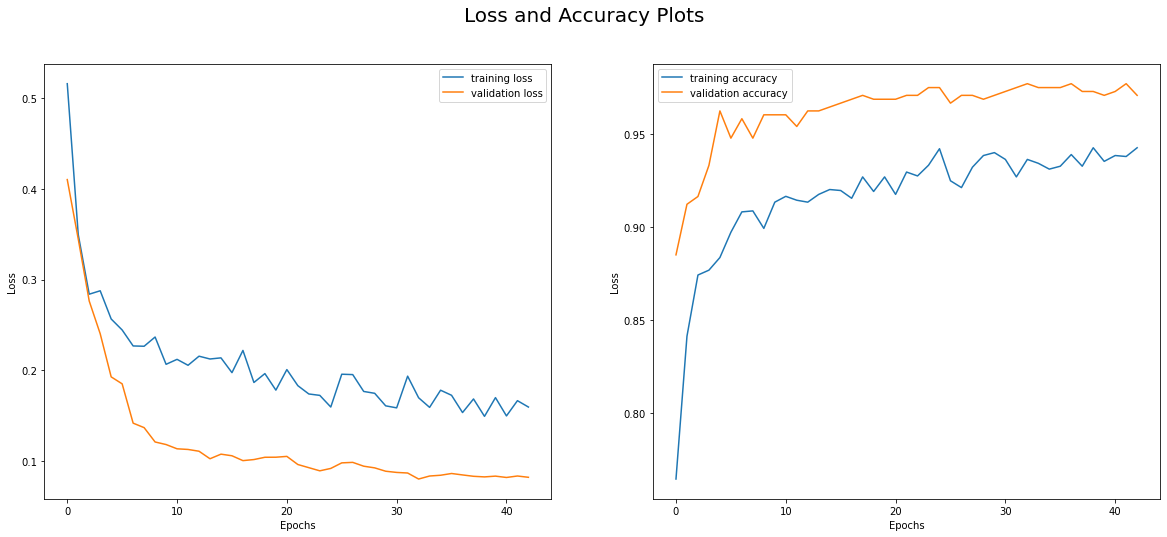

In [48]:
# plot training loss and accuracy

plt.figure(figsize=(20, 8))
plt.suptitle('Loss and Accuracy Plots', fontsize=20)

plt.subplot(1, 2, 1)
plt.plot(hist2.history['loss'], label='training loss')
plt.plot(hist2.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist2.history['accuracy'], label='training accuracy')
plt.plot(hist2.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [49]:
enet_train.evaluate(test_images, test_labels)

19/19 [==============================] - 2s 112ms/step - loss: 0.0778 - accuracy: 0.9732


[0.07775481045246124, 0.9731993079185486]

In [50]:
preds = enet_train.predict(test_images)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print(f'Accuracy: {acc}%')
print(f'Precision: {precision}%')
print(f'Recall: {recall}%')
print(f'F1-score: {2*precision*recall/(precision+recall)}%')
print(f'Specificity: {(tn/(tn + fp))*100}%')

CONFUSION MATRIX ------------------
[[278  12]
 [  4 303]]

TEST METRICS ----------------------
Accuracy: 97.31993299832496%
Precision: 96.19047619047619%
Recall: 98.69706840390879%
F1-score: 97.42765273311898%
Specificity: 95.86206896551724%


Transfer learning with EfficientNet also gives great results with an accuracy score of 97.3% and a F1-score of 97.4%, but it looks like Resnet is the better performing model for this dataset. Transfer learning gave the most consistent results with a F1-score of 97-98% through multiple iterations.

# Appendix

# CNN Model

I created a CNN from scratch to see if I could make a simpler model that performs just as well as using transfer learning.

In [260]:
model = tf.keras.Sequential([
    models.Sequential(
    [
        layers.RandomRotation(factor=0.15, input_shape=(224, 224, 3)),
        layers.RandomFlip(),
        layers.Rescaling(scale=1./255)
    ]),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_20 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 conv2d_49 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_68 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 batch_normalization_69 (Bat  (None, 112, 112, 32)   

In [261]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001, decay=0.01), metrics=tf.keras.metrics.AUC(name="auc"))

In [262]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
hist = model.fit(train_dataset, epochs=40, validation_data=validation_dataset, callbacks=[es])

Epoch 1/40
60/60 [==============================] - 13s 190ms/step - loss: 0.5653 - auc: 0.8085 - val_loss: 0.6123 - val_auc: 0.7358
Epoch 2/40
60/60 [==============================] - 12s 186ms/step - loss: 0.4341 - auc: 0.8845 - val_loss: 3.0901 - val_auc: 0.4885
Epoch 3/40
60/60 [==============================] - 12s 185ms/step - loss: 0.3613 - auc: 0.9175 - val_loss: 3.3031 - val_auc: 0.4842
Epoch 4/40
60/60 [==============================] - 12s 187ms/step - loss: 0.3407 - auc: 0.9268 - val_loss: 3.9046 - val_auc: 0.5000
Epoch 5/40
60/60 [==============================] - 11s 184ms/step - loss: 0.2791 - auc: 0.9507 - val_loss: 2.9746 - val_auc: 0.6041
Epoch 6/40
60/60 [==============================] - 12s 186ms/step - loss: 0.2475 - auc: 0.9613 - val_loss: 2.0230 - val_auc: 0.8085
Epoch 7/40
60/60 [==============================] - 12s 184ms/step - loss: 0.2263 - auc: 0.9683 - val_loss: 1.4115 - val_auc: 0.8212
Epoch 8/40
60/60 [==============================] - 12s 187ms/step - 

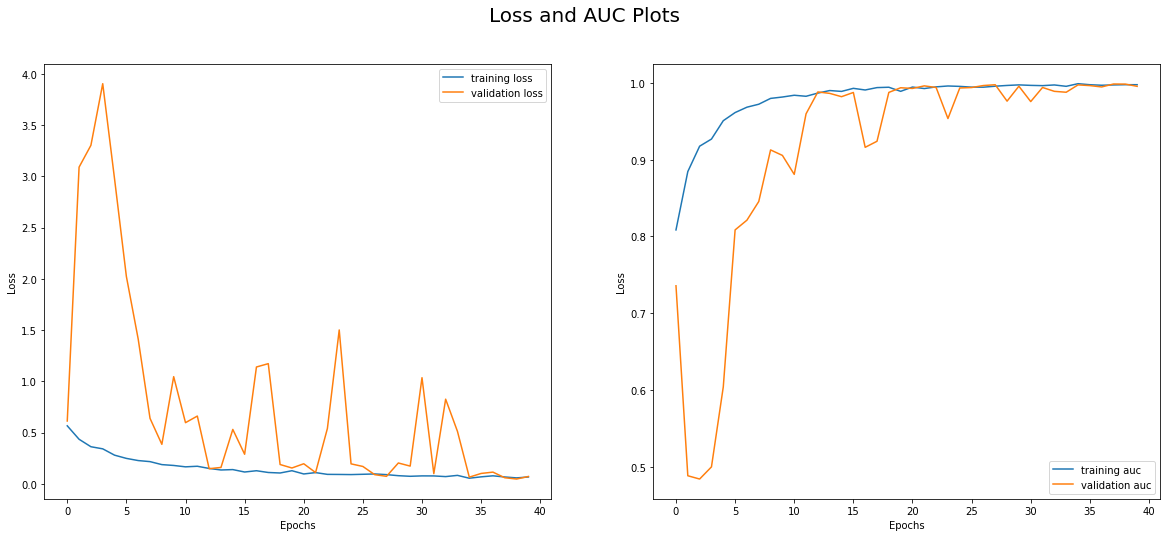

In [263]:
# plot training loss and auc

plt.figure(figsize=(20, 8))
plt.suptitle('Loss and AUC Plots', fontsize=20)

plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='training loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['auc'], label='training auc')
plt.plot(hist.history['val_auc'], label='validation auc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [264]:
model.evaluate(test_images, test_labels)

19/19 [==============================] - 1s 41ms/step - loss: 0.0788 - auc: 0.9952


[0.07880555838346481, 0.9951869249343872]

In [265]:
preds = model.predict(test_images)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print(f'Accuracy: {acc}%')
print(f'Precision: {precision}%')
print(f'Recall: {recall}%')
print(f'F1-score: {2*precision*recall/(precision+recall)}%')
print(f'Specificity: {(tn/(tn + fp))*100}%')

CONFUSION MATRIX ------------------
[[278  12]
 [  5 302]]

TEST METRICS ----------------------
Accuracy: 97.15242881072027%
Precision: 96.17834394904459%
Recall: 98.37133550488599%
F1-score: 97.2624798711755%
Specificity: 95.86206896551724%


The CNN model I built performs extremely well with an accuracy score of 97% and a F1-score of 98%. It performs just as well as the EfficientNet model, but underperforms when compared to the Resnet model.

# Predicting a Sequence of Images

I will be attempting to predict whether or not a sequence of images shows a page being flipped or not flipped.

In [2]:
## create variables for image locations on computer

train = './images/training'
train_f = './images/training/flip'
train_nf = './images/training/notflip'

test = './images/testing'
test_f = './images/testing/flip'
test_nf = './images/testing/notflip'

In [3]:
## find total number of training and testing pictures

print('Number of Training flip pictures: ', len(os.listdir(train_f)))
print('Number of Training not flip pictures: ', len(os.listdir(train_nf)))
print('Number of Testing flip pictures: ', len(os.listdir(test_f)))
print('Number of Testing not flip pictures: ', len(os.listdir(test_nf)))

Number of Training flip pictures:  1162
Number of Training not flip pictures:  1230
Number of Testing flip pictures:  290
Number of Testing not flip pictures:  307


I'll create a function to get all the sequences of images into a list. The images are already split into sequences by their filenames.

In [4]:
def sequence_images(img_location, train_test, flip):
    img_list = []
    sequence_list = []
    s_num = '0001'

    for img in os.listdir(img_location):
        if img[:4] == s_num:
            sequence_list.append(imread(f'./images/{train_test}/{flip}/{img}'))
        elif img[:4] != s_num:
            img_list.append(sequence_list)
            sequence_list = [imread(f'./images/{train_test}/{flip}/{img}')]
            s_num = img[:4]
            
    return img_list

In [5]:
train_flip = sequence_images(train_f, 'training', 'flip')
train_notflip = sequence_images(train_nf, 'training', 'notflip')
test_flip = sequence_images(test_f, 'testing', 'flip')
test_notflip = sequence_images(test_nf, 'testing', 'notflip')

In [6]:
## resize training images

train_flip = [[resize(x, (224, 224)) for x in sequence] for sequence in train_flip]
train_notflip = [[resize(x, (224, 224)) for x in sequence] for sequence in train_notflip]

In [7]:
## resize test images

test_flip = [[resize(x, (224, 224)) for x in sequence] for sequence in test_flip]
test_notflip = [[resize(x, (224, 224)) for x in sequence] for sequence in test_notflip]

In [8]:
## see the minimum number of images in each sequence for training/testing sets

print(min(map(len, train_flip)))
print(min(map(len, train_notflip)))
print(min(map(len, test_flip)))
print(min(map(len, test_notflip)))

7
6
1
2


In [9]:
## make sure the minimum length of the sequence of test images is greater than or equal to 5

test_flip = [sequence for sequence in test_flip if len(sequence) >= 5]
test_notflip = [sequence for sequence in test_notflip if len(sequence) >= 5]

I need all sequences to be the same length in order to run them through the model. I will be looking to make image sequence lengths of 5 for the training and testing set. For image sequences longer than 5 images, I will be using the middle 5 images from each sequence.

In [10]:
## get the middle 5 images for training/testing set

for pics in [train_flip, train_notflip, test_flip, test_notflip]:
    for sequence in pics:
        length = len(sequence)
        diff = length - 5
        front = diff - diff//2
        back = diff//2

        if back == 0:
            sequence[:] = sequence[front:]
        else:
            sequence[:] = sequence[front:-back]

In [33]:
## make sure the length of all sequences is the same

print(min(map(len, train_flip)), max(map(len, train_flip)))
print(min(map(len, train_notflip)), max(map(len, train_notflip)))
print(min(map(len, test_flip)), max(map(len, test_flip)))
print(min(map(len, test_notflip)), max(map(len, test_notflip)))

5 5
5 5
5 5
5 5


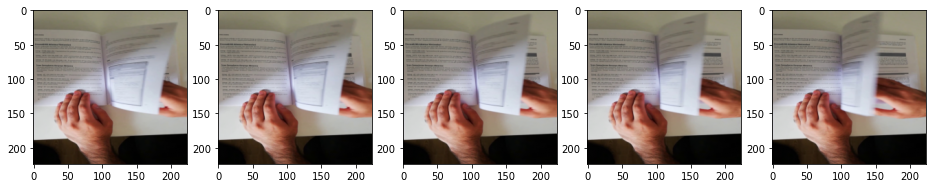

In [12]:
## take a look at a sequence of images

plt.figure(figsize=(16, 8))

for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_flip[0][i])

In [13]:
## combine training/testing flip/notflip images into a list

training_data = []
testing_data = []

for label in [train_notflip, train_flip]:
    for img in label:
        if label == train_notflip:
            training_data.append([img, 0])
        else:
            training_data.append([img, 1])

for label in [test_notflip, test_flip]:
    for img in label:
        if label == test_notflip:
            testing_data.append([img, 0])
        else:
            testing_data.append([img, 1])

In [14]:
random.shuffle(training_data)
random.shuffle(testing_data)

In [15]:
## separate images into features and labels

X_train, X_test, y_train, y_test = [], [], [], []

for features, label in training_data:
    X_train.append(features)
    y_train.append(label)
    
for features, label in testing_data:
    X_test.append(features)
    y_test.append(label)
    
X_train = np.array(X_train)
X_test = np.array(X_test)
    
y_train = np.array(y_train)
y_test = np.array(y_test)

## CNN Model

In [26]:
## create a cnn from scratch

cnn_model = tf.keras.Sequential([
    models.Sequential(
    [
        layers.RandomRotation(factor=0.15, input_shape=(224, 224, 3)),
        layers.RandomFlip(),
        layers.Rescaling(scale=1./255)
    ]),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    
    layers.Flatten()
])

cnn_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_11 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 conv2d_25 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_30 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 batch_normalization_31 (Bat  (None, 112, 112, 32)   

In [27]:
model = tf.keras.Sequential()
model.add(layers.TimeDistributed(cnn_model, input_shape=(5, 224, 224, 3)))
model.add(layers.GRU(128))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 5, 100352)        288800    
 tributed)                                                       
                                                                 
 gru_3 (GRU)                 (None, 128)               38585088  
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_36 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)              

In [28]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, decay=0.01), metrics=['acc'])

In [29]:
seq_history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=10)

Epoch 1/50
10/10 [==============================] - 72s 7s/step - loss: 0.8981 - acc: 0.5543 - val_loss: 1.8714 - val_acc: 0.3913
Epoch 2/50
10/10 [==============================] - 65s 6s/step - loss: 0.8069 - acc: 0.5109 - val_loss: 2.0530 - val_acc: 0.3913
Epoch 3/50
10/10 [==============================] - 63s 6s/step - loss: 0.7386 - acc: 0.6630 - val_loss: 3.1459 - val_acc: 0.3913
Epoch 4/50
10/10 [==============================] - 60s 6s/step - loss: 0.7242 - acc: 0.5652 - val_loss: 1.7183 - val_acc: 0.3913
Epoch 5/50
10/10 [==============================] - 64s 6s/step - loss: 0.7573 - acc: 0.5761 - val_loss: 1.3152 - val_acc: 0.3913
Epoch 6/50
10/10 [==============================] - 62s 6s/step - loss: 0.6993 - acc: 0.5870 - val_loss: 1.9033 - val_acc: 0.3913
Epoch 7/50
10/10 [==============================] - 62s 6s/step - loss: 0.7607 - acc: 0.5978 - val_loss: 1.6132 - val_acc: 0.3913
Epoch 8/50
10/10 [==============================] - 64s 6s/step - loss: 0.6146 - acc: 0.66

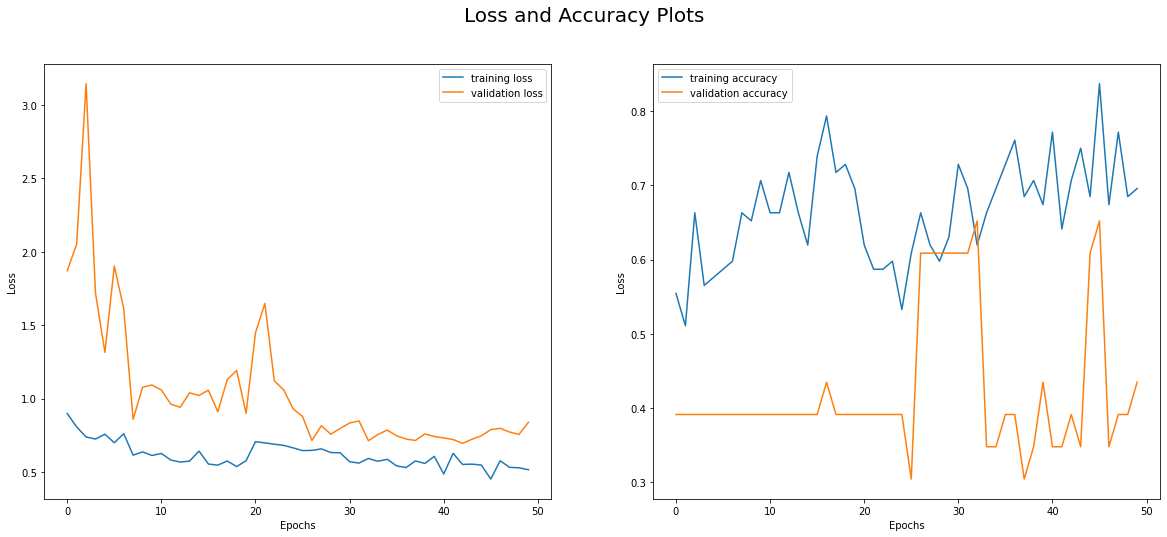

In [30]:
# plot training loss and accuracy

plt.figure(figsize=(20, 8))
plt.suptitle('Loss and Accuracy Plots', fontsize=20)

plt.subplot(1, 2, 1)
plt.plot(seq_history.history['loss'], label='training loss')
plt.plot(seq_history.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(seq_history.history['acc'], label='training accuracy')
plt.plot(seq_history.history['val_acc'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 8s 4s/step - loss: 0.6862 - acc: 0.5079


[0.6861867308616638, 0.5079365372657776]

In [32]:
preds = model.predict(X_test)

acc = accuracy_score(y_test, np.round(preds))*100
cm = confusion_matrix(y_test, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print(f'Accuracy: {acc}%')
print(f'Precision: {precision}%')
print(f'Recall: {recall}%')
print(f'F1-score: {2*precision*recall/(precision+recall)}%')
print(f'Specificity: {(tn/(tn + fp))*100}%')

CONFUSION MATRIX ------------------
[[ 4 30]
 [ 1 28]]

TEST METRICS ----------------------
Accuracy: 50.79365079365079%
Precision: 48.275862068965516%
Recall: 96.55172413793103%
F1-score: 64.36781609195403%
Specificity: 11.76470588235294%


# ResNet

In [131]:
resnet_model = tf.keras.Sequential([
    models.Sequential(
    [
        layers.RandomRotation(factor=0.15, input_shape=(224, 224, 3)),
        layers.RandomFlip()
    ]),
    layers.Lambda(tf.keras.applications.resnet50.preprocess_input),
    resnet,
    layers.GlobalAveragePooling2D()
])

In [132]:
model = tf.keras.Sequential()

model.add(layers.TimeDistributed(resnet_model, input_shape=(5, 224, 224, 3)))
model.add(layers.GRU(128))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_17 (TimeDi  (None, 5, 2048)          23587712  
 stributed)                                                      
                                                                 
 gru_10 (GRU)                (None, 128)               836352    
                                                                 
 dense_26 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_53 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 1)               

In [133]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, decay=0.01), metrics=['acc'])

In [134]:
rn_seq_history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=10)

Epoch 1/50
10/10 [==============================] - 35s 3s/step - loss: 0.7498 - acc: 0.5217 - val_loss: 0.6633 - val_acc: 0.6522
Epoch 2/50
10/10 [==============================] - 29s 3s/step - loss: 0.6964 - acc: 0.5978 - val_loss: 0.6816 - val_acc: 0.6522
Epoch 3/50
10/10 [==============================] - 29s 3s/step - loss: 0.6994 - acc: 0.5326 - val_loss: 0.6572 - val_acc: 0.6522
Epoch 4/50
10/10 [==============================] - 29s 3s/step - loss: 0.6751 - acc: 0.6848 - val_loss: 0.7519 - val_acc: 0.3478
Epoch 5/50
10/10 [==============================] - 29s 3s/step - loss: 0.6638 - acc: 0.5870 - val_loss: 0.9216 - val_acc: 0.3478
Epoch 6/50
10/10 [==============================] - 29s 3s/step - loss: 0.7093 - acc: 0.5652 - val_loss: 0.9774 - val_acc: 0.3478
Epoch 7/50
10/10 [==============================] - 29s 3s/step - loss: 0.6346 - acc: 0.6630 - val_loss: 1.3335 - val_acc: 0.3478
Epoch 8/50
10/10 [==============================] - 29s 3s/step - loss: 0.5838 - acc: 0.69

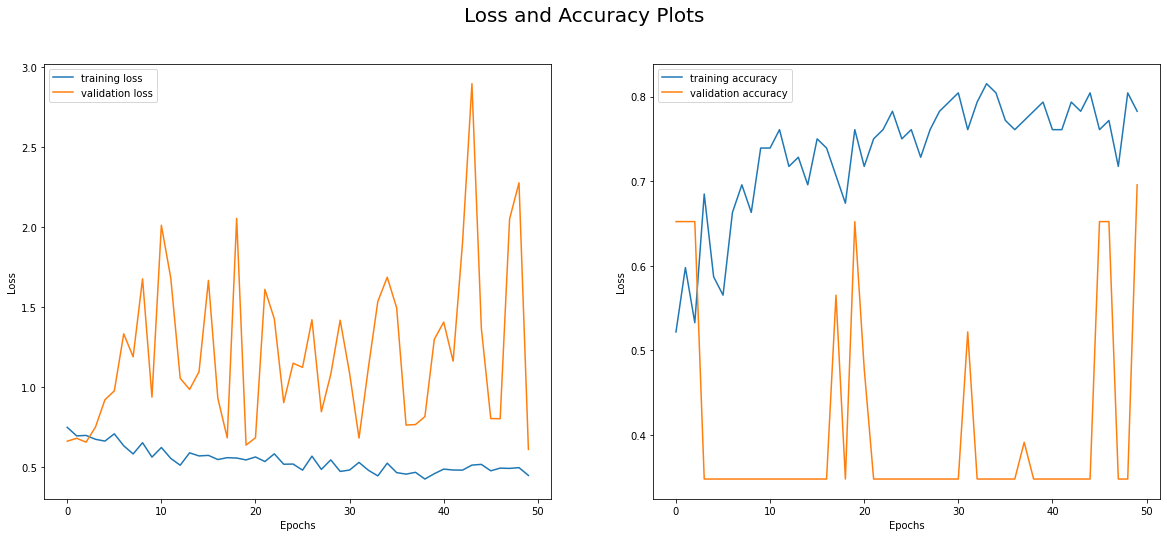

In [135]:
# plot training loss and accuracy

plt.figure(figsize=(20, 8))
plt.suptitle('Loss and Accuracy Plots', fontsize=20)

plt.subplot(1, 2, 1)
plt.plot(rn_seq_history.history['loss'], label='training loss')
plt.plot(rn_seq_history.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rn_seq_history.history['acc'], label='training accuracy')
plt.plot(rn_seq_history.history['val_acc'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [136]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 15s 7s/step - loss: 0.7483 - acc: 0.4921


[0.7482884526252747, 0.4920634925365448]

In [139]:
preds = model.predict(X_test)

acc = accuracy_score(y_test, np.round(preds))*100
cm = confusion_matrix(y_test, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print(f'Accuracy: {acc}%')
print(f'Precision: {precision}%')
print(f'Recall: {recall}%')
print(f'F1-score: {2*precision*recall/(precision+recall)}%')
print(f'Specificity: {(tn/(tn + fp))*100}%')

CONFUSION MATRIX ------------------
[[ 2 32]
 [ 0 29]]

TEST METRICS ----------------------
Accuracy: 49.2063492063492%
Precision: 47.540983606557376%
Recall: 100.0%
F1-score: 64.44444444444444%
Specificity: 5.88235294117647%


Both models do not perform well at all in correctly predicting the classes for the images. It seems like the models are slightly overfitting to the training set because they are able to reach ~80% accuracy during training, however the accuracy on the validation and testing sets are stuck at 50% which is just as good as randomly guessing.